# Predicting Discharge Reference Capacity using Voltage Rebound Information 

**NOTE**: Using parameters estimated from a logisitic-like function fit on the rebound curve, as well as max measured temp in celsius.

**NOTE**: This analysis does not take into account a cell's cycle history, therefore time is not a predictor and is not considered in this analysis.

**NOTE**: Definitions for logisitc-like estimated parameters:
  
*  L: Asymptotic maximum value  
*  A: Scaling factor  
*  x0: Midpoint of the curve  
*  b: Growth rate  

In [1]:
# load packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load data
n45_sub = pd.read_csv('C:/Users/Worm/Downloads/New_NASA_Rebound/nasa45_WORSTsubset60.csv')
n47_sub = pd.read_csv('C:/Users/Worm/Downloads/New_NASA_Rebound/nasa47_WORSTsubset60.csv')
n48_sub = pd.read_csv('C:/Users/Worm/Downloads/New_NASA_Rebound/nasa48_WORSTsubset60.csv')

In [3]:
n_all = pd.concat([n45_sub, n47_sub, n48_sub], axis = 0)

In [4]:
print(n_all.shape)

(207, 8)


In [5]:
n_all.head()

Step         L         A         x0         b  Reference Capacity  \
0   0.0  3.384803  1.394815  10.964803  1.208226            4356.636   
1   4.0  3.387944  1.400959  10.530423  1.382754            3856.567   
2   6.0  3.390364  1.402381  10.216914  1.515721            3703.252   
3   8.0  3.379569  1.410586  10.110922  1.568636            3594.173   
4  10.0  3.382131  1.399149   9.956479  1.572134            3506.276   

   Max_Temp  Ambient_Temperature  
0    15.710                  4.0  
1    16.327                  4.0  
2    16.190                  4.0  
3    16.445                  4.0  
4    16.652                  4.0

In [6]:
n_all = n_all.drop(columns = ['Ambient_Temperature', 'Step', 'Max_Temp'])

In [7]:
n_all.isnull().sum()

L                     0
A                     0
x0                    0
b                     0
Reference Capacity    0
dtype: int64

In [8]:
n_all = n_all.dropna()

In [9]:
n_all.duplicated().any()

False

In [10]:
n_all.head()

L         A         x0         b  Reference Capacity
0  3.384803  1.394815  10.964803  1.208226            4356.636
1  3.387944  1.400959  10.530423  1.382754            3856.567
2  3.390364  1.402381  10.216914  1.515721            3703.252
3  3.379569  1.410586  10.110922  1.568636            3594.173
4  3.382131  1.399149   9.956479  1.572134            3506.276

In [11]:
n_all.tail()

L         A         x0         b  Reference Capacity
63  3.688682  1.002682  24.818156  0.547492            4679.544
64  3.658913  0.959913  19.951517  0.563711            4568.834
65  3.198999  0.508999   0.308223  5.962126            4519.852
66  3.190154  0.506154   7.791413  3.232986            4507.155
67  3.207044  0.517044   7.870066  3.238898            4403.258

In [12]:
n_all.describe()

L           A          x0           b  Reference Capacity
count  207.000000  207.000000  207.000000  207.000000          207.000000
mean     3.582307    1.200309   19.332878    0.925040         4099.555184
std      0.193399    0.208658   13.790054    0.623384          867.215342
min      3.190154    0.506154    0.308223    0.408083         2678.509000
25%      3.418597    1.038640   10.407526    0.513663         3127.438500
50%      3.521444    1.217215   12.620086    0.632083         4359.665000
75%      3.721801    1.421400   22.849599    1.457900         4654.944500
max      4.066146    1.467714   77.285146    5.962126         6134.145000

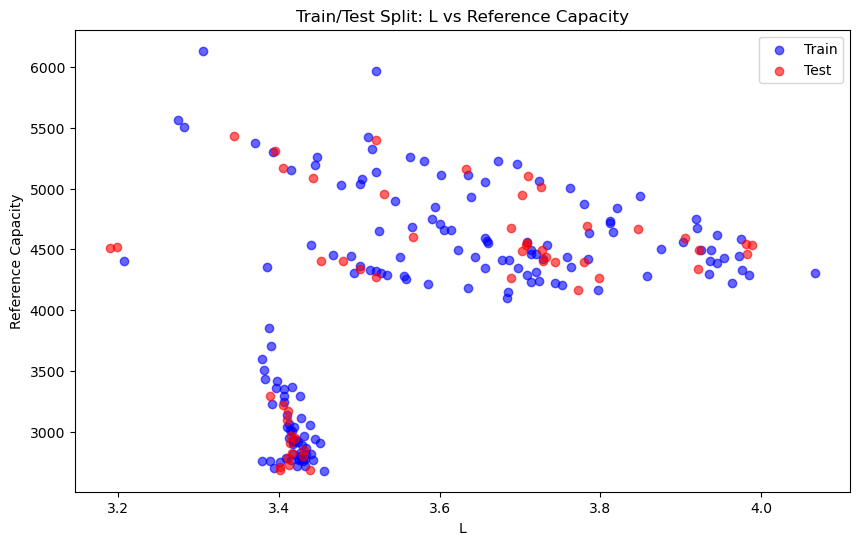

In [13]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define features (X) and target (y)
y = n_all["Reference Capacity"]  # Target
X = n_all.drop('Reference Capacity', axis = 1) # Features

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Plot the data
plt.figure(figsize=(10, 6))

# Plot training points in blue
plt.scatter(X_train['L'], y_train, color="blue", label="Train", alpha=0.6)

# Plot testing points in red
plt.scatter(X_test['L'], y_test, color="red", label="Test", alpha=0.6)

# Add labels, legend, and title
plt.xlabel("L")
plt.ylabel("Reference Capacity")
plt.title("Train/Test Split: L vs Reference Capacity")
plt.legend()
plt.show()

In [14]:
print(X_train.shape, y_train.shape)
print('\n', X_test.shape, y_test.shape)

(155, 4) (155,)

 (52, 4) (52,)


In [15]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Polynomial Degree 2": Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ])
}

# Initialize cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to compute metrics
def evaluate_model(model, X, y):
    rmse_scores = []
    mae_scores = []
    
    for train_idx, val_idx in kf.split(X):
        # Split data into training and validation for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = model.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
    
    # Return scores
    return rmse_scores, mae_scores

# Convert data to numpy arrays for consistent indexing (X should be 2D)
y_train_np = y_train.to_numpy()

# Evaluate models
for name, model in models.items():
    print(f"Evaluating: {name}")
    
    # Evaluate the model
    rmse_scores, mae_scores = evaluate_model(model, X_train_scaled, y_train_np)
    
    # Print fold-wise metrics
    print(f"  RMSE (folds): {rmse_scores}")
    print(f"  MAE (folds): {mae_scores}")
    
    # Print average metrics
    print(f"  Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"  Average MAE: {np.mean(mae_scores):.4f}")
        
    print("-" * 50)

Evaluating: Linear Regression
  RMSE (folds): [304.3087312913101, 226.23759048175756, 582.7366080838638, 265.75777296021056, 258.3014869382135]
  MAE (folds): [231.63176341178894, 190.8137985974068, 255.98698534658243, 204.58569611880893, 220.75140931340644]
  Average RMSE: 327.4684
  Average MAE: 220.7539
--------------------------------------------------
Evaluating: Ridge Regression
  RMSE (folds): [306.32940356451945, 227.62852806019873, 378.6883785017585, 271.35102167736335, 253.31174754489996]
  MAE (folds): [231.73034133473197, 194.1873674773778, 227.69712779677798, 202.8988041590553, 210.1254140134087]
  Average RMSE: 287.4618
  Average MAE: 213.3278
--------------------------------------------------
Evaluating: Lasso Regression
  RMSE (folds): [304.38284184351465, 226.25100127228797, 578.87875496423, 265.93368111789493, 258.10308190470107]
  MAE (folds): [231.63575829711868, 190.9143067753013, 255.01679063424461, 204.49625598113266, 220.3981679794281]
  Average RMSE: 326.7099
 

In [17]:
models.keys()

dict_keys(['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net', 'Polynomial Degree 2'])

In [18]:
models['Elastic Net'].coef_

array([-161.64532146, -544.81197011,  157.87230351, -397.12446102])

In [19]:
models['Elastic Net'].intercept_

4086.098373872547

In [20]:
X_train_scaled

array([[-8.53048228e-01,  1.05009556e+00, -6.77065698e-01,
         1.04788480e+00],
       [-8.08405631e-01,  1.12215824e+00, -6.74857810e-01,
         1.22426852e+00],
       [-7.75100281e-01,  1.25842245e+00, -5.89513366e-01,
         1.16016034e+00],
       [ 1.78055943e-01, -3.74615217e-01, -2.46699348e-01,
        -6.88946794e-01],
       [ 1.88887747e+00,  2.09732185e-01,  2.25023863e+00,
        -9.26660259e-01],
       [ 1.42396810e+00, -2.08609755e-01,  1.58274208e+00,
        -9.60998587e-01],
       [-1.04693468e+00,  9.62172828e-01, -6.79333216e-01,
         1.40542167e+00],
       [ 2.86313444e-02, -6.05376616e-01, -3.21403104e-01,
        -5.17105798e-01],
       [-7.41313112e-01,  1.18540826e+00, -6.05070943e-01,
         1.13181269e+00],
       [-1.25825080e-01, -7.26031272e-01, -4.09410084e-01,
        -4.79739109e-01],
       [ 7.62117704e-01,  1.11128672e-01,  1.96258767e-01,
        -7.25169603e-01],
       [ 6.14967664e-01, -1.01127739e+00,  1.69488988e-01,
      

In [21]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Models to evaluate
models = {
    "SVM with RBF Kernel": SVR(kernel='rbf'),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Initialize cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to compute metrics
def evaluate_model(model, X, y):
    rmse_scores = []
    mae_scores = []
    
    for train_idx, val_idx in kf.split(X):
        # Split data into training and validation for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = model.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
    
    # Return scores
    return rmse_scores, mae_scores

# Convert data to numpy arrays for consistent indexing (X should be 2D)
y_train_np = y_train.to_numpy()

# Evaluate models
for name, model in models.items():
    print(f"Evaluating: {name}")
    
    # Evaluate the model
    rmse_scores, mae_scores = evaluate_model(model, X_train_scaled, y_train_np)
    
    # Print fold-wise metrics
    print(f"  RMSE (folds): {rmse_scores}")
    print(f"  MAE (folds): {mae_scores}")
    
    # Print average metrics
    print(f"  Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"  Average MAE: {np.mean(mae_scores):.4f}")
        
    print("-" * 50)

Evaluating: SVM with RBF Kernel
  RMSE (folds): [802.7614142261352, 933.7384750562812, 842.315211456647, 947.2891809925925, 881.4070137719176]
  MAE (folds): [598.866148891202, 734.5111797545891, 652.1985519977743, 742.8883025138078, 711.3270093863963]
  Average RMSE: 881.5023
  Average MAE: 687.9582
--------------------------------------------------
Evaluating: Decision Tree
  RMSE (folds): [288.4615358171133, 274.77749158640364, 320.6649068827599, 296.8668201738977, 239.87710547916933]
  MAE (folds): [196.98080645161292, 164.10780645161302, 191.76174193548397, 192.72338709677413, 168.0862903225807]
  Average RMSE: 284.1296
  Average MAE: 182.7320
--------------------------------------------------
Evaluating: Random Forest
  RMSE (folds): [267.45895211493183, 203.29785420175463, 224.41955355197, 256.72072123377, 175.83648864935202]
  MAE (folds): [175.56800451612887, 125.95700483871026, 158.14258129032217, 165.04234225806627, 135.79159096774168]
  Average RMSE: 225.5467
  Average MAE:

In [22]:
from sklearn.model_selection import GridSearchCV
import joblib  # To save the model

# Models to evaluate
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Hyperparameter grids
param_grids = {

    "Decision Tree": {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "XGBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
}

# Initialize cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to compute metrics
def evaluate_model(model, param_grid, X, y):
    rmse_scores = []
    mae_scores = []
    
    # Hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X, y)
    
    best_model = grid_search.best_estimator_  # Get the best model from GridSearchCV
    print(f"Best parameters for {model}: {grid_search.best_params_}")
    
    # Save the best model for Random Forest
    if isinstance(best_model, RandomForestRegressor):
        joblib.dump(best_model, 'best_random_forest_model.joblib')
        print("Best Random Forest model saved as 'best_random_forest_model.joblib'")

    # Save the best model for Decision Tree
    if isinstance(best_model, DecisionTreeRegressor):
        joblib.dump(best_model, 'best_decision_tree_model.joblib')
        print("Best Decision Tree model saved as 'best_decision_tree_model.joblib'")
    
    # Evaluate the best model using cross-validation
    for train_idx, val_idx in kf.split(X):
        # Split data into training and validation for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Fit the model
        best_model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = best_model.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
    
    # Return scores
    return rmse_scores, mae_scores

# Convert data to numpy arrays for consistent indexing (X should be 2D)
y_train_np = y_train.to_numpy()

# Evaluate models
for name, model in models.items():
    print(f"Evaluating: {name}")
    
    # Get the hyperparameter grid for the model
    param_grid = param_grids[name]
    
    # Evaluate the model with hyperparameter tuning
    rmse_scores, mae_scores = evaluate_model(model, param_grid, X_train_scaled, y_train_np)
    
    # Print fold-wise metrics
    print(f"  RMSE (folds): {rmse_scores}")
    print(f"  MAE (folds): {mae_scores}")
    
    # Print average metrics
    print(f"  Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"  Average MAE: {np.mean(mae_scores):.4f}")
        
    print("-" * 50)

Evaluating: Decision Tree
Best parameters for DecisionTreeRegressor(random_state=42): {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Decision Tree model saved as 'best_decision_tree_model.joblib'
  RMSE (folds): [277.9217592911782, 291.746812589482, 278.9589584979705, 264.1845726858162, 297.05475486393954]
  MAE (folds): [190.9024623655914, 200.8437795698925, 165.2437849462366, 180.8122634408603, 208.4291043010753]
  Average RMSE: 281.9734
  Average MAE: 189.2463
--------------------------------------------------
Evaluating: Random Forest
Best parameters for RandomForestRegressor(random_state=42): {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest model saved as 'best_random_forest_model.joblib'
  RMSE (folds): [264.83025456835327, 186.84079420667965, 216.81852209188034, 250.9686100413466, 176.96557963090493]
  MAE (folds): [173.131788519593, 122.5698897369616, 152.92320641584107, 162.45720209351063, 135.56492

C:\Users\Worm\anaconda3\envs\duke\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
4 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Worm\anaconda3\envs\duke\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Worm\anaconda3\envs\duke\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\Worm\anaconda3\envs\duke\Lib\site-packages\xgboost\sklearn.py", line 1081, in fit
    train_dmatrix, evals = _wrap_evaluation

Best parameters for XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...): {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
  RMSE (folds): [219.19815786634723, 207.0675573598103, 221.44376540443605, 244.31629453492863, 217.9134537731177]
  MAE (folds): [135.45282195060477, 138.8

In [23]:
models['Random Forest'].fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [24]:
testpred = models['Random Forest'].predict(X_test_scaled)

In [25]:
import numpy as np

In [26]:
4.8,11,31

(4.8, 11, 31)

In [27]:
xnew = X_test*np.random.normal([1,1,1,1],[.04,.08,.11,.31])

In [28]:
xnew - X_test

L         A        x0         b
22  0.021029 -0.013059  1.936667  0.032604
15  0.018618 -0.016225  0.566813  0.116975
3   0.018284 -0.009981  0.460308  0.057896
26  0.020268 -0.013736  1.194302  0.038475
27  0.021803 -0.014756  3.411334  0.030698
9   0.018525 -0.016167  0.562941  0.117822
30  0.020379 -0.014070  1.186836  0.038754
65  0.018874 -0.010991  0.638484  0.059674
18  0.018645 -0.016109  0.563332  0.112659
9   0.020282 -0.011587  1.254955  0.032660
32  0.020683 -0.012510  1.913262  0.034050
30  0.018666 -0.016130  0.570008  0.108382
16  0.020240 -0.011647  1.141751  0.034343
66  0.017439 -0.005744  0.434579  0.240209
55  0.019140 -0.011417  0.647201  0.053715
57  0.020658 -0.012402  1.585790  0.037687
25  0.021346 -0.013854  2.483359  0.032038
50  0.020760 -0.012602  1.702712  0.037071
14  0.018821 -0.010802  0.539434  0.051263
5   0.018559 -0.010495  0.485295  0.053089
54  0.019024 -0.011358  0.661369  0.054861
31  0.021767 -0.014739  3.399120  0.031321
34  0.019498 -0.012468  0.751183  0.046610
31  0.020467 -0.014388  1.313448  0.038342
69  0.018595 -0.016255  0.616616  0.126359
25  0.018694 -0.016302  0.560992  0.112038
25  0.020275 -0.013774  1.152468  0.038598
16  0.018652 -0.016272  0.562727  0.115659
2   0.019245 -0.009583  0.649140  0.037959
45  0.021436 -0.013904  2.655991  0.033817
15  0.020370 -0.011781  1.328103  0.032850
68  0.018594 -0.016129  0.621128  0.127178
66  0.018652 -0.016205  0.624832  0.124419
50  0.020622 -0.014643  1.408948  0.039123
8   0.019862 -0.010760  0.869041  0.034964
28  0.020379 -0.014103  1.282017  0.038392
68  0.019248 -0.011596  0.703906  0.053565
28  0.021765 -0.014699  3.486361  0.030777
45  0.018752 -0.016299  0.577895  0.105571
43  0.020168 -0.013813  1.042823  0.041647
65  0.018675 -0.016354  0.635330  0.121792
38  0.021440 -0.013900  2.704145  0.032817
16  0.019301 -0.011832  0.675199  0.043796
63  0.020165 -0.011378  1.384274  0.040678
67  0.018659 -0.016173  0.617337  0.125949
12  0.018614 -0.010507  0.568264  0.053169
65  0.017488 -0.005776  0.017192  0.442982
54  0.020241 -0.011457  1.196476  0.039431
38  0.018757 -0.016422  0.582918  0.110019
24  0.018670 -0.016197  0.558008  0.112572
60  0.018796 -0.016583  0.629335  0.111167
55  0.020406 -0.011935  1.280839  0.038843

In [29]:
xnew = scaler.transform(xnew)

In [30]:
testprednew = models['Random Forest'].predict(xnew)
testprednew

array([4596.32349, 2957.14628, 5337.70155, 4309.92364, 4324.77089,
       2879.363  , 4304.14052, 4692.16288, 3198.87106, 4906.96785,
       4394.57446, 2987.68229, 4622.17585, 4732.93756, 4645.08985,
       4379.45268, 4404.46307, 4356.14878, 5152.30105, 5262.83923,
       4503.72665, 4272.84416, 4314.25324, 4286.37174, 2908.87471,
       2973.23332, 4320.40798, 2973.82123, 5644.94965, 4381.54282,
       4655.70653, 2937.35362, 2905.53145, 4222.94379, 5014.25764,
       4309.65539, 4432.34257, 4324.5439 , 2947.88835, 4236.59324,
       2852.55557, 4388.40117, 4651.065  , 4626.56015, 2909.09952,
       5248.03921, 4737.91998, 4653.546  , 2861.37912, 2998.57806,
       2815.76438, 4452.04397])

In [31]:
testpred

array([4703.50019, 3231.87056, 5395.27757, 4432.08641, 4567.63826,
       3335.77566, 4359.8086 , 4856.13313, 3124.27   , 4845.86455,
       4564.95078, 3060.71602, 4771.56362, 4729.19465, 4846.32407,
       4419.51261, 4612.63296, 4467.42544, 5167.66144, 5199.11164,
       4659.71901, 4424.55573, 4563.03009, 4289.03431, 2737.24896,
       3026.93204, 4410.58842, 3088.29455, 5716.09185, 4368.2281 ,
       4763.13683, 2793.84289, 2783.10811, 4267.62613, 5079.84524,
       4345.45273, 4420.10488, 4565.10356, 2797.91363, 4348.0313 ,
       2833.7257 , 4446.49915, 4951.47441, 4671.33907, 2791.38782,
       5184.48978, 4737.91998, 4728.74397, 2817.65007, 3054.36276,
       2836.4133 , 4497.7024 ])

In [32]:
from sklearn.metrics import mean_absolute_percentage_error

In [33]:
mean_absolute_percentage_error(testpred, testprednew)

0.027312932863892532

DecisionTreeRegressor(random_state=42) 165.73362919398005
RandomForestRegressor(random_state=42) 153.9246556005303
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...) 158.12878473960853


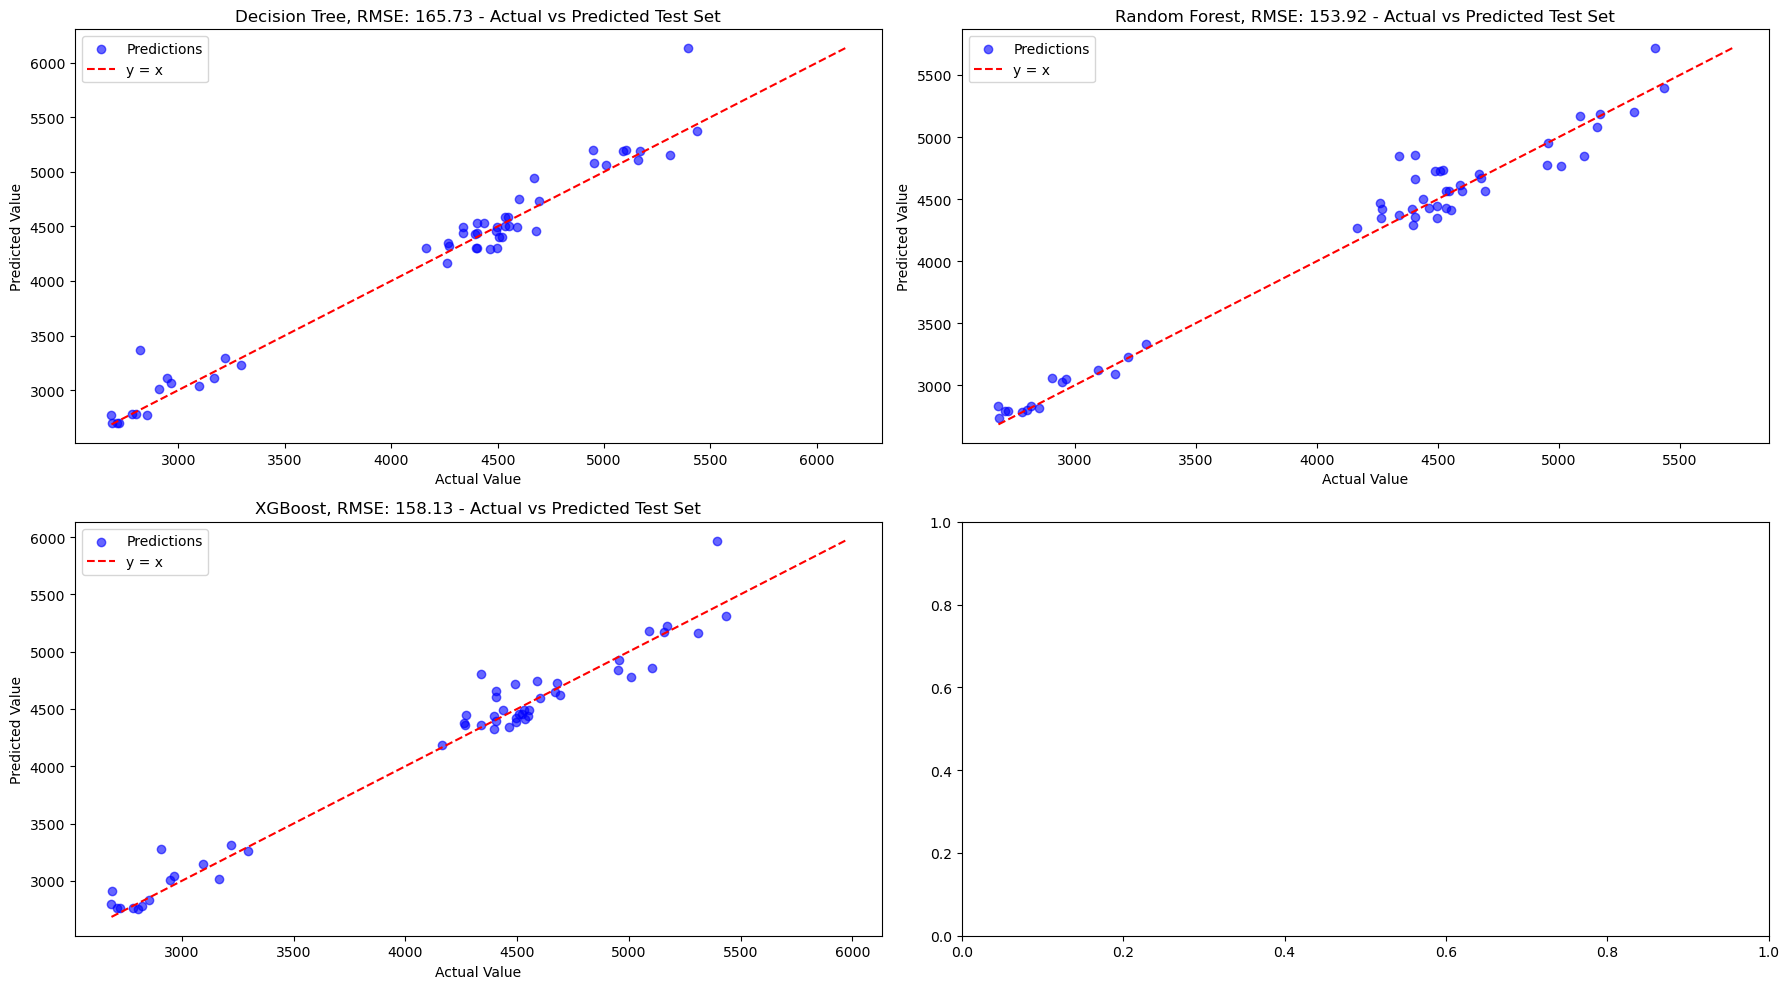

In [34]:
# Define the feature names
features = ['L', 'A', 'x0', 'b']

# Create a subplot grid (1x2)
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Flatten axes array for easier indexing
axes = axes.flatten()

# List to store RMSE values for each model
rmse_values = []

# Convert y_test to numpy for plotting
y_test_np = y_test.to_numpy()

# Fit each model, extract coefficients, and plot
for i, (name, model) in enumerate(models.items()):
    # Fit the model
    model.fit(X_train_scaled, y_train_np)
    
    # Calculate RMSE for the current model
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
    rmse_values.append(rmse)

    print(model, rmse)

    # Plot Actual vs Predicted
    axes[i].scatter(y_test_np, y_pred, label='Predictions', color='blue', alpha=0.6)
    
    # Plot the "actual = predicted" line (y = x line)
    min_val = min(np.min(y_test_np), np.min(y_pred))
    max_val = max(np.max(y_test_np), np.max(y_pred))
    axes[i].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="y = x")
    
    # Set titles and labels
    axes[i].set_title(f'{name}, RMSE: {rmse.round(2)} - Actual vs Predicted Test Set')
    axes[i].set_xlabel('Actual Value')
    axes[i].set_ylabel('Predicted Value')
    axes[i].legend()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [35]:
# List to store percentage RMSE values
percent_rmse_values = {}

# Convert y_test to numpy for easier handling
y_test_np = y_test.to_numpy()

# Evaluate each model
for name, model in models.items():
    # Fit the model
    model.fit(X_train_scaled, y_train_np)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
    
    # Calculate percentage RMSE
    mean_actual = np.mean(y_test_np)
    percent_rmse = (rmse / mean_actual) * 100
    
    # Store the percentage RMSE
    percent_rmse_values[name] = percent_rmse

# Print out the percentage RMSE for each model
for name, percent_rmse in percent_rmse_values.items():
    print(f"{name} - Percentage RMSE: {percent_rmse:.2f}%")

Decision Tree - Percentage RMSE: 4.00%
Random Forest - Percentage RMSE: 3.71%
XGBoost - Percentage RMSE: 3.81%


In [36]:
features

['L', 'A', 'x0', 'b']

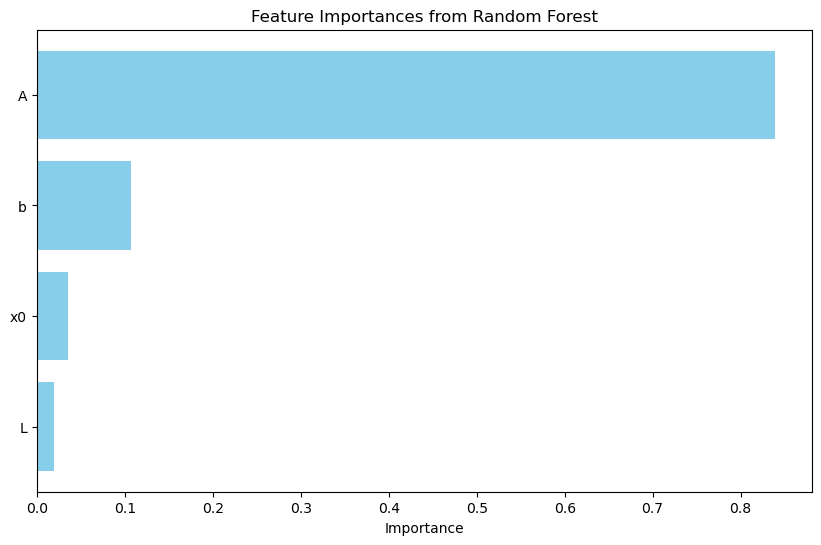

In [37]:
best_model = joblib.load('best_random_forest_model.joblib')

# Get feature importances from the model
importances = best_model.feature_importances_

# Create a DataFrame for better visualization (optional, but can make it easier to view)
importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the importances by value
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.savefig('random_forest_nasa.png')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.show()

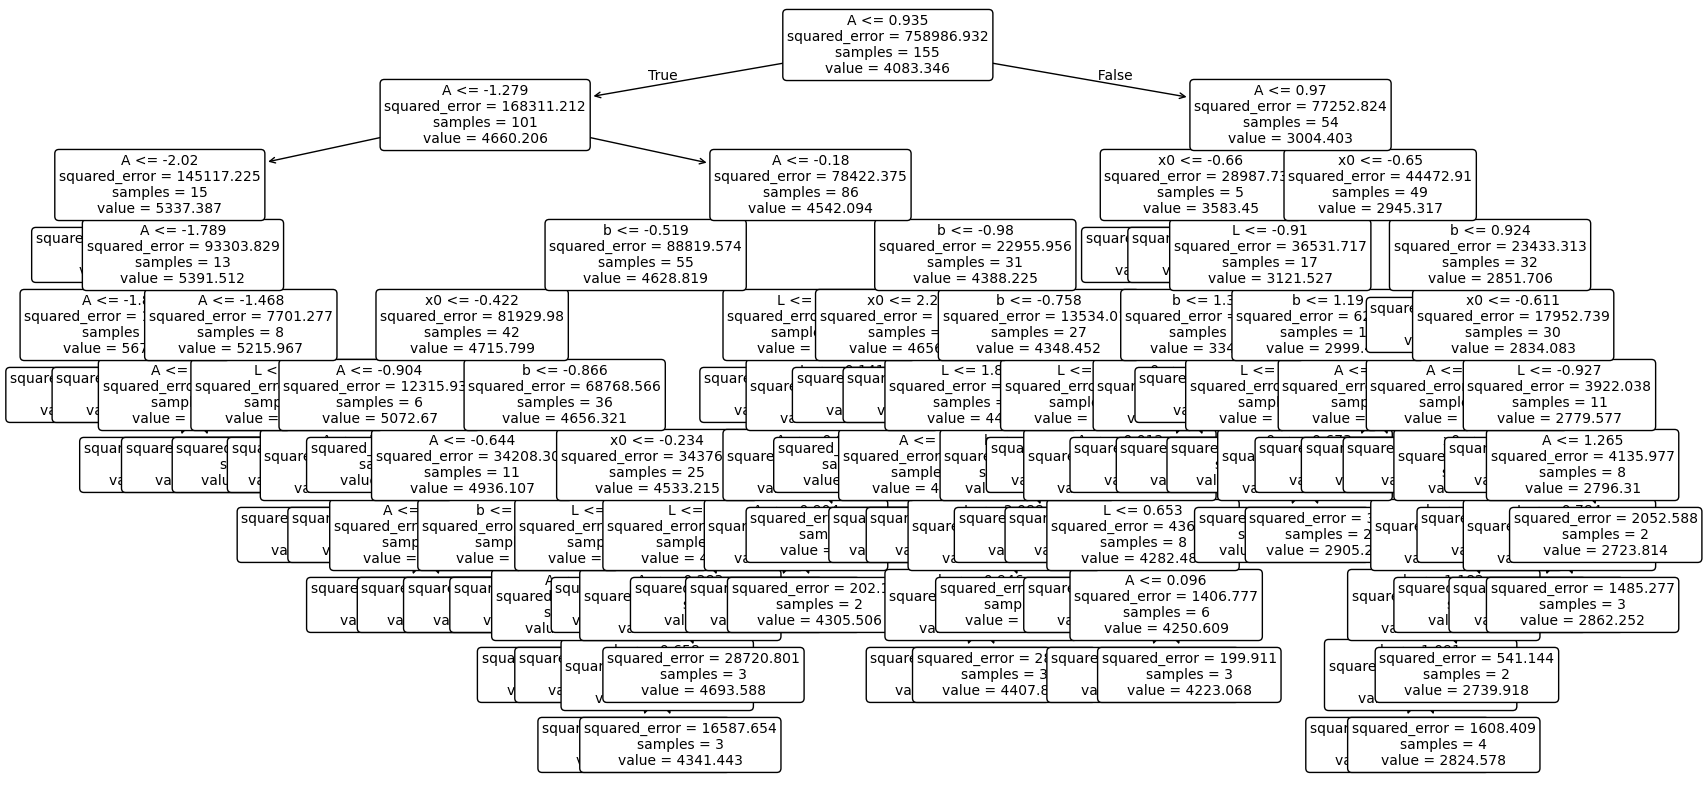

In [38]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Load the model
best_model = joblib.load('best_decision_tree_model.joblib')

# Plot the tree
plt.figure(figsize=(20, 10))  # Adjust the size as needed
plot_tree(best_model, 
          feature_names=features,  # Replace with your feature names
          # class_names=['class1', 'class2'],  # Replace with your class names if classification
          filled=False, 
          rounded=True, 
          fontsize=10)
plt.show()

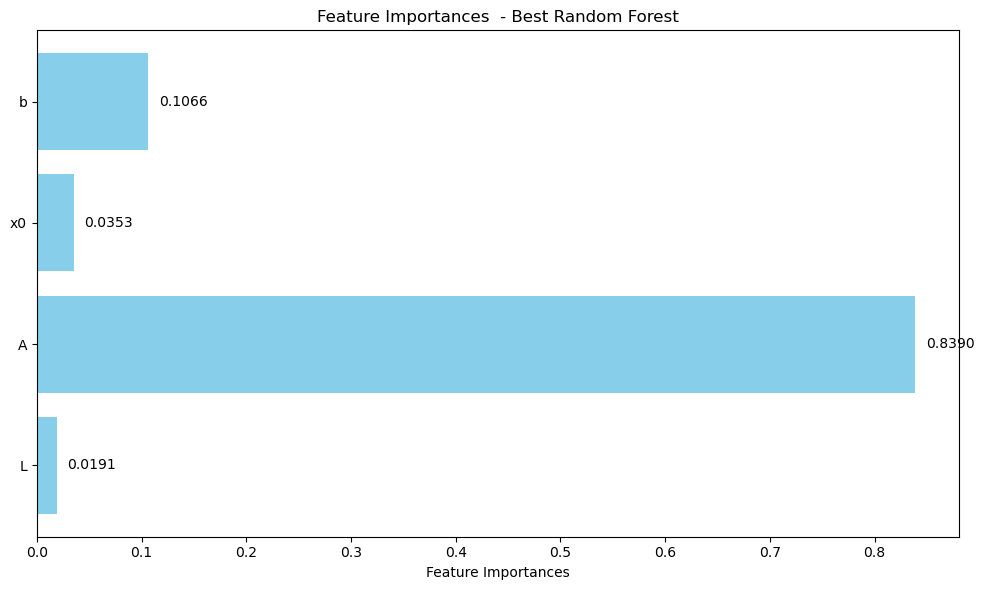

In [39]:
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Feature Importances')
plt.title('Feature Importances  - Best Random Forest')

# Annotate the plot with the actual coefficients
for i, (coef, feature) in enumerate(zip(importances, features)):
    plt.text(importances[i] + 0.01, i, f'{coef:.4f}', va='center')

plt.tight_layout()
plt.show()